<a href="https://colab.research.google.com/github/Martolins/Sentiment140Bert/blob/master/sentiment140BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Caricamento librerie




In [3]:
import os
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

# 2. Caricamento dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive') 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive






## 2.1 Lettura dataset dal csv ##

In [ ]:
import pandas as pd
dataset = pd.read_csv("/content/drive/My Drive/trainingandtestdata/training.1600000.processed.noemoticon.csv", names=['target', 'ids', 'date', 'flag', 'user', 'text'],
                encoding='latin-1',error_bad_lines=False)
dataset.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


## 2.2 Pulizia del dataset ##

Il dataset contiene 800000 esempi positivi e altrettanti esempi negativi. Puliamo il dataset, sostituendo le etichette per una maggiore chiarezza: "0" sentiment negativo, "1" sentiment positivo.

Cancelliamo le colonne non necessarie ai fini del task, lasciando solamente 'target' e 'text'.


In [ ]:
dataset.target.value_counts()

4    800000
0    800000
Name: target, dtype: int64

In [ ]:
dataset.target = dataset.target.replace({0: 0, 4: 1})
dataset.target.value_counts()

1    800000
0    800000
Name: target, dtype: int64

In [ ]:
dataset = dataset.drop(columns=['ids','date','flag','user'],axis=0)
dataset.head()

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


## 2.3 Sottocampionamento del dataset ##

Consideriamo solo 5000 record del dataset per il training.

In [ ]:
dataset = dataset.sample(n=5000)
dataset.target.value_counts()

1    2504
0    2496
Name: target, dtype: int64

In [ ]:
dataset.to_csv("/content/drive/My Drive/sentiment140-subset.csv", index=False)

In [4]:
import pandas as pd
dataset = pd.read_csv("/content/drive/My Drive/sentiment140-subset.csv", error_bad_lines=False)
dataset.head(0)

,target,text


## 2.4 Training set e validation set ##

Randomicamente splittiamo l'intero dataset di training in 90% training set e il restante 10% validation set.  


In [5]:
from sklearn.model_selection import train_test_split

X = dataset["text"].values
y = dataset["target"].values

X_train, X_val, y_train, y_val =\
    train_test_split(X, y, test_size=0.1, random_state=42)

## 2.5 Caricamento dataset di test ##


In [6]:
# Load test data
test_data = pd.read_csv("/content/drive/My Drive/trainingandtestdata/testdata.manual.2009.06.14.csv", names=['target', 'ids', 'date', 'flag', 'user', 'text'])
test_data.sample(5)
# Keep important columns
test_data = test_data[['text']]

# Display 5 samples from the test data
test_data.sample(5)

,text
398,@sportsguy33 Time Warner = epic fail
253,@the_real_usher LeBron is cool. I like his pe...
216,Man accosts Roger Federer during French Open h...
228,Safari 4 is fast :) Even on my shitty AT&amp;T...
251,is it me or is this the best the playoffs have...


# 3. Set up GPU per il training 

In [7]:
import torch

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla K80


# 4. BERT

## 4.1 Installazione della libreria Hugging Face ##




In [8]:
!pip install transformers==2.8.0

     |████████████████████████████████| 573kB 2.7MB/s 
     |████████████████████████████████| 890kB 13.3MB/s 
     |████████████████████████████████| 3.7MB 16.2MB/s 
     |████████████████████████████████| 1.1MB 28.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=1215b932e0a681b16ec09f5a23b53d8d2707f827e397e8b97c434167edd10d1a
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


## 4.2 Tokenizazione e pulizia dell'input ##


In [9]:
def text_clean(text):
    """
    - Rimuove i tag (es. '@chrishasboobs')
    - Corregge gli errori (es. '&amp;' to '&')
    - Rimuove gli spazi bianchi finali
    """
    text = re.sub(r'(@.*?)[\s]', ' ', text)

    text = re.sub(r'&amp;', '&', text)

    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [10]:
# Stampa esempio di "pulizia" del primo tweet
print('Original: ', X[0])
print('Processed: ', text_clean(X[0]))

Original:  @chrishasboobs AHHH I HOPE YOUR OK!!! 
Processed:  AHHH I HOPE YOUR OK!!!


### 4.2.1 BERT Tokenizer ###

In [11]:
from transformers import BertTokenizer

# Carica BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Definizione di una funzione per tokenizzare un insieme di tweet da dare in input a BERT
def preprocessing(data):
  
    input_ids = []
    attention_masks = []

    # Per ogni tweet
    for tweet in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=text_clean(tweet),  
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            return_attention_mask=True      # Return attention mask
            )
        
    
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Converte le liste in tensori
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

Prima della tokenizzazione, calcoliamo la lunghezza della frase più lunga, in modo tale che il padding consenta di rendere tutti gli input della stessa dimensione.

In [12]:
import random

# Di tutti i record del dataset prendiamo il campo text che contiene il tweet 
all_tweets = dataset.text.values

encoded_tweets = [tokenizer.encode(sent, add_special_tokens=True,max_length=510) for sent in all_tweets]


# Trova la lunghezza massima
max_len = max([len(sent) for sent in encoded_tweets])
print('Max length: ', max_len)

Max length:  137


In [13]:
MAX_LEN = 137

# Stampa un esempio del preprocessing per il primo tweet 
token_ids = list(preprocessing([X[0]])[0].squeeze().numpy())
print('Original tweet: ', X[0])
print('Token IDs: ', token_ids)

# Preprocessing di tutti i tweet del training set e del validation set 
print('Start of preprocessing...')
train_inputs, train_masks = preprocessing(X_train)
val_inputs, val_masks = preprocessing(X_val)

Original tweet:  @chrishasboobs AHHH I HOPE YOUR OK!!! 
Token IDs:  [101, 6289, 23644, 1045, 3246, 2115, 7929, 999, 999, 999, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Start of preprocessing...


In [14]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Converte le label in un tensore
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)

# E' consigliato utilizzare batch size di 16 o 32 
batch_size = 32

# Crea DataLoader per il training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Crea DataLoader per il validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

## 4.3 Training del modello ##


### 4.3.1 Creazione BertClassifier ###

In [15]:
%%time
import torch
import torch.nn as nn
from transformers import BertModel

# Crea BertClassfier per il task di classificazione
class BertClassifier(nn.Module):
    
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()

        # Lo strato di classificazione è costituito da una fully connected con 768 neuroni,50 di strato nascosto e 2 di output
        D_in, H, D_out = 768, 50, 2

        # Carica BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instanzia la rete neurale fully connected per la classificazione
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            nn.Linear(H, D_out)
        )

        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
       
        # Fornisce l'input per BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Estrae il token [CLS] che verrà dato in input al classificatore
        last_hidden_state_cls = outputs[0][:, 0, :]
        logits = self.classifier(last_hidden_state_cls)

        return logits

CPU times: user 47 µs, sys: 0 ns, total: 47 µs
Wall time: 51.3 µs


### 4.3.2 Ottimizzazione per fine-tune di Bert Classifier ###


In [16]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs=4):
   
    # Instanzia Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # Esegue il modello sulla GPU
    bert_classifier.to(device)

    # Usa Adam per l'ottimizzazione in combinazione con un learning rate lineare
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Calcola il numero totale degli step di training
    total_steps = len(train_dataloader) * epochs

    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

### 4.3.3 Training ###

In [17]:
import random
import time

# Specifica la funzione di loss
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Inizio del training
    print("Start training...\n")
    for epoch_i in range(epochs):
       
        #Training
        # Costruisco una tabella per riportare i risultati del training
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Misura il tempo trascorso per ogni epoca
        t0_epoch, t0_batch = time.time(), time.time()

        # Azzera le variabili all'inizio di ogni epoca
        total_loss, batch_loss, batch_counts = 0, 0, 0

        model.train()

        # Per ogni batch del training data
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1

            # Carica il batch sulla GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            model.zero_grad()

            logits = model(b_input_ids, b_attn_mask)

            # Calcola la loss 
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Calcola il gradiente con la funzione backward
            loss.backward()

            # Previene esplosione del gradiente 
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Aggiornamento parametri e del learning rate
            optimizer.step()
            scheduler.step()

            # Stampa la loss e il tempo impiegato per ogni 20 batch
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                time_elapsed = time.time() - t0_batch

                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calcola la loss media sull'intero training set 
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
    

        #### TO DO
        # Evaluation   
        if evaluation == True:
            
            # Misura le performance del modello sul validation set
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            time_elapsed = time.time() - t0_epoch
        
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training completato!")


def evaluate(model, val_dataloader):
    
    # Misura le performance del modello sul validation set
    model.eval()

  
    val_accuracy = []
    val_loss = []

    # Per ogni batch nel validation set
    for batch in val_dataloader:
        # Carica batch sulla GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

      
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Calcola la loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Prende le predizioni
        preds = torch.argmax(logits, dim=1).flatten()

        # Calcola l'accuratezza
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Calcola l'accuratezza media e la loss sul validation set
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [18]:
set_seed(42)    # per la riproducibilità dell'esperimento
bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
train(bert_classifier, train_dataloader, val_dataloader, epochs=2, evaluation=True)


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------


/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)


   1    |   20    |   0.619585   |     -      |     -     |   29.30  
   1    |   40    |   0.500009   |     -      |     -     |   27.80  
   1    |   60    |   0.504098   |     -      |     -     |   27.63  
   1    |   80    |   0.424576   |     -      |     -     |   27.61  
   1    |   100   |   0.480156   |     -      |     -     |   27.58  
   1    |   120   |   0.454084   |     -      |     -     |   27.60  
   1    |   140   |   0.461181   |     -      |     -     |   27.17  
----------------------------------------------------------------------
   1    |    -    |   0.492861   |  0.443222  |   80.51   |  202.63  
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |   20    |   0.271880   |     -      |     -     |   28.95  
   2    |   40    |   0.297368   |     -      |     -     |   27.56  
   2    |   60 

## 4.4 Valutazione della predizione sul validation set ##

In questo step calcoliamo la predizione applicando in uscita una softMax in modo da restituire i valori di probabilità. Disegnamo il grafico 

In [24]:
import torch.nn.functional as F

def bert_predict(model, test_dataloader):
    
    model.eval()

    all_logits = []

    for batch in test_dataloader:
        # Carica il batch sulla GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

     
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatena i logits di ogni batch
    all_logits = torch.cat(all_logits, dim=0)

    # Applica la softmax per calcolare la probabilità
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

In [25]:
from sklearn.metrics import accuracy_score, roc_curve, auc
'''
AUC è compreso tra 0 e 1. 
Un modello le cui predizioni sono 100% sbagliate ha un AUC di 0.0;
Un modello le cui predizioni sono 100% giuste ha un AUC di 1.0.

'''
def evaluate_roc(probs, y_true):
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # Prende l'accuratezza sul validation set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

AUC: 0.8870
Accuracy: 81.40%


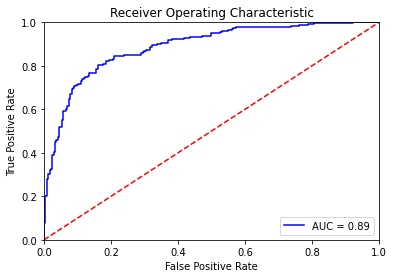

In [26]:
# Calcola la predizione sul validation set
probs = bert_predict(bert_classifier, val_dataloader)

# Valuta i risultati ottenuti
evaluate_roc(probs, y_val)

La retta rossa rappresenta una curva limite della curva ROC : ovvero il caso di un classificatore casuale e l'area sottesa è 0.5.

AUC 0.8870 vuol dire che il modello ha l'89% di probabilità di classificare correttamente.

# 5. Predizioni sentiment sul Test set 






## 5.1 Data Preparation ##

Preprocessing del test set, per preparare l'input da fornire a Bert

In [39]:
# Run preprocessing sul test set
print('Start of preprocessing...')
test_inputs, test_masks = preprocessing(test_data.text)

# Prepara il test set da dare a BERT
test_dataset = TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=32)

Start of preprocessing...


## 5.2 Predizioni ##

In [28]:
# Calcola la predizione sul test set
probs = bert_predict(bert_classifier, test_dataloader)

# Determina il sentiment a partire dalle probabilità
threshold = 0.9
preds = np.where(probs[:, 1] > threshold, 1, 0)

Prendiamo un esempio di 20 tweet per verificare la classificazione

In [41]:
output = test_data[preds==1]
print("10 esempi di tweet classificati come positivi:")
list(output.sample(10).text)

10 esempi di tweet classificati come positivi:


["reading Michael Palin book, The Python Years...great book. I also recommend Warren Buffet &amp; Nelson Mandela's bio",
 'RT @clashmore: http://bit.ly/SOYv7  Great article by Malcolm Gladwell.',
 "@phyreman9 Google is always a good place to look. Should've mentioned I worked on the Mustang w/ my Dad, @KimbleT.",
 '@johncmayer is Bobby Flay joining you?',
 'RT @jquery: The Ultimate jQuery List - http://jquerylist.com/',
 'Nike Air Yeezy Khaki/Pink Colorway Release - http://shar.es/bjfN',
 'getting ready to test out some burger receipes this weekend. Bobby Flay has some great receipes to try. Thanks Bobby.',
 'Any twitter to aprs apps yet?',
 'just got back from the movies.  went to see the new night at the museum with rachel.  it was good',
 'My dentist appt today was actually quite enjoyable.']

In [49]:
output = test_data[preds==0]
print("10 esempi di tweet classificati come negativi:")
list(output.sample(10).text)

10 esempi di tweet classificati come negativi:


['Sony coupon code.. Expires soon.. http://www.coupondork.com/r/1796',
 'Recovering from surgery..wishing @julesrenner was here :(',
 "@ludajuice Lebron is a Beast, but I'm still cheering 4 the A..til the end.",
 '@ambcharlesfield lol. Ah my skin is itchy :( damn lawnmowing.',
 'is upset about the whole GM thing. life as i know it is so screwed up',
 'Obama: Nationalization of GM to be short-term   (AP) http://tinyurl.com/md347r',
 'THE DENTIST LIED! " U WON\'T FEEL ANY DISCOMORT! PROB WON\'T EVEN NEED PAIN PILLS" MAN U TWIPPIN THIS SHIT HURT!! HOW MANY PILLS CAN I TAKE!!',
 'annoying new trend on the internets:  people picking apart michael lewis and malcolm gladwell.  nobody wants to read that.',
 'Naive Bayes using EM for Text Classification. Really Frustrating...',
 "is Twitter's connections API broken? Some tweets didn't make it to Twitter..."]